<h>William Kiger - Kristopher Gallagher<br>
<h>DLH 598<br>
<h>Resnet-18 mode

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import seaborn as sn 
from collections import Counter

In [2]:
data_csv = pd.read_csv("fitzpatrick17k.csv")
data_csv.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


In [3]:
model = torch.load("resnet_18_derm_model_test.pt")
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d    
test_transformer = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])    

In [5]:
# got this logic from the below link
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):    
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
import re

In [7]:
data_dir = r"C:\Users\WilliamKiger\Desktop\FinalProject-main\FinalProject-main\data_valid_only"
dataset = ImageFolderWithPaths(root=data_dir, transform=test_transformer)
data_set_data_dir = DataLoader(dataset=dataset)

In [8]:
dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 890
    Root location: C:\Users\WilliamKiger\Desktop\FinalProject-main\FinalProject-main\data_valid_only
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# dataset.class_to_idx.items()
for batch in dataset:
    print(batch[1])
    print(batch[2])
    break

0
C:\Users\WilliamKiger\Desktop\FinalProject-main\FinalProject-main\data_valid_only\data\valid\allergic_contact_dermatitis\10.jpg


In [10]:
data_csv.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
# Create a loader for the entire the test set
test_load_all = DataLoader(data_set_data_dir, batch_size=10000, shuffle=False)
# test_load_all = DataLoader(data['valid'], batch_size=10000, shuffle=False)
# class_names = list(idx_to_class.values()) #classes are stored in a dictionary
class_names = {0: 'allergic_contact_dermatitis', 1: 'basal_cell_carcinoma', 2: 'folliculitis', 
               3: 'lichen_planus', 4: 'lupus_erythematosus', 5: 'neutrophilic_dermatoses', 
               6: 'photodermatoses', 7: 'psoriasis', 8: 'sarcoidosis', 9: 'squamous_cell_carcinoma'}
class_names = list(class_names.values())
# print(class_names)

model.eval() #eval mode

index = 0

incorrect_pred = []

with torch.no_grad():
    for batch in dataset: 
#         print(batch[0]) #data
#         print(batch[1]) #label
#         print(batch[2]) #image path
        
        label_correct = batch[1]
        image_path = batch[2]
        
        if torch.cuda.is_available():
            test_image_tensor = batch[0].view(1, 3, 224, 224).cuda()
        else:
            test_image_tensor = batch[0].view(1, 3, 224, 224)
        
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(10, dim=1) 
        cls = class_names[topclass[0][0]]
        score = topk.cpu().numpy()[0][0]
#         print(cls, score) #psoriasis 0.29854122
        corr_str_lbl = class_names[label_correct]
    
        #wrong prediction -- log skintone of wrong diagnosis
        if not (corr_str_lbl ==  cls):
            index = re.findall('[0-9]+', image_path) #grabbing the image number to look up the fitzpatrick score
            #look up index and get skintone
            idx = index[0]
            incorrect_pred.append(data_csv.iloc[int(idx)]['fitzpatrick_scale'])
        

In [13]:
len(incorrect_pred)

831

Text(0, 0.5, 'Miss Frequency')

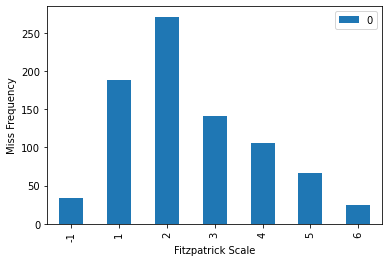

In [14]:
incorrect_pred = sorted(incorrect_pred)
count = Counter(incorrect_pred)
df = pd.DataFrame.from_dict(count, orient='index')

df.plot(kind='bar')
plt.xlabel("Fitzpatrick Scale")
plt.ylabel("Miss Frequency")